In [1]:
# Initialization
# 1. Get the relevant dependencies 
import json
import os
import sys 
import random
import math
import numpy as np
import pandas as pd
import inspect
import os.path
import matplotlib.pyplot as plt
import heapq
from math import atan2,pi

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from event_model import event_model as em

# resource switch
dataset={
    'small':'datasets/small_dataset',
    'bsphiphi': 'datasets/bsphiphi',
    'minibias': 'datasets/minibias'
}

In [2]:
# analysis variables
DATASET = 'bsphiphi'
load_percent = 100
shuffle = False

# read in the events -> from the folder choosen 
loaded_events = []
for (dirpath, dirnames, filenames) in os.walk(os.path.abspath(os.path.join('..', dataset[DATASET]))):
    if shuffle:
        random.shuffle(filenames)

    for i, filename in enumerate(filenames):
        # Get an event
        f = open(os.path.realpath(os.path.join(dirpath, filename)))
        json_data = json.loads(f.read())
        loaded_events = loaded_events + [em.event(json_data)]
        f.close()
        
        if i == int(load_percent * len(filenames)):
            print(f'successfully loaded {i} events from {DATASET}')
            break


print(f'Successfully loaded {len(loaded_events)} events from {DATASET} dataset.' )

Successfully loaded 1000 events from bsphiphi dataset.


In [3]:
class particle(object):
    def __init__(self, particle, event):
        self.key = particle[0]
        self.pid = particle[1]
        self.p = particle[2]
        self.pt = particle[3]
        self.eta = particle[4]
        self.phi = particle[5]
        self.isLong = particle[6]
        self.isDown = particle[7]
        self.hasVelo = particle[8]
        self.hasUT = particle[9]
        self.hasScifi = particle[10]
        self.fromBeautyDecay = particle[11]
        self.fromCharmDecay = particle[12]
        self.fromStrangeDecay = particle[13]
        self.charge = particle[14]
        self.hits = particle[15]
        self.track = [hit for hit in event.hits if hit.id in self.hits]
        self.is_decay = any([particle[11], particle[12], particle[13]])
        self.is_noise = len(self.track) < 3
        # compare dist of 2 points to center
        #self.left_to_right = (math.sqrt(self.track[0].x**2 * self.track[0].y**2) < math.sqrt(self.track[1].x**2 * self.track[1].y**2))

In [4]:
all_event_particles = []
hits_to_remove = []
all_track_hits = []

for i,event in enumerate(loaded_events[:]):
    #print(i)
    for part in event.montecarlo.get('particles'):
        temp_particle = particle(part, event)
        all_event_particles = all_event_particles + [temp_particle]
        for hit in temp_particle.track:
            hits_to_remove.append(hit.id)
        all_track_hits = all_track_hits + temp_particle.track

noise_hits = [hit for hit in event.hits if hit.id not in hits_to_remove]
noise_coords = np.zeros(shape=(2,len(noise_hits)))

for i, hit in enumerate(noise_hits):
    noise_coords[0,i]= hit.x
    noise_coords[1,i]= hit.y

track_hit_coords = np.zeros(shape=(2, len(all_track_hits))) 
for i, hit in enumerate(all_track_hits):
    track_hit_coords[0,i] = hit.x
    track_hit_coords[1,i] = hit.y

In [5]:
all_particles = all_event_particles
print(f'Number of particles were looking at {len(all_particles)}')


Number of particles were looking at 332526


## General overview of the angles

In [9]:
# Compute the angles

angle_xz_deg_list = []
angle_yz_deg_list = []
angle_xy_deg_list = []

angle_xz_rad_list =[]
angle_yz_rad_list = []
angle_xy_rad_list =[]

for particle in all_particles:
    hit1 = particle.track[0]    
    hit2 = particle.track[-1]


    # ANGLES
    angle_xz = atan2((hit2.x - hit1.x),(hit2.z - hit1.z))
    angle_yz = atan2((hit2.y - hit1.y),(hit2.z - hit1.z))
    angle_xy = atan2((hit2.x - hit1.x),(hit2.y - hit1.y))
    
    angle_xz_deg = math.degrees(angle_xz)
    angle_yz_deg = math.degrees(angle_yz)
    angle_xy_deg = math.degrees(angle_xy)

    angle_xz_rad_list.append(angle_xz)
    angle_yz_rad_list.append(angle_yz)
    angle_xy_rad_list.append(angle_xy)

    angle_xz_deg_list.append(angle_xz_deg)
    angle_yz_deg_list.append(angle_yz_deg)
    angle_xy_deg_list.append(angle_xy_deg)

print(f'Number of particles were looking at {len(all_particles)}.')

Number of particles were looking at 332526.


In [10]:
#Fct to plot the angles

def plot_angles_analysis(angle_rad_list,angle_deg_list, title=None):

    angles = [angle for angle in angle_rad_list]
    bins_number = 360
    plt.clf()
    ax = plt.subplot(1, 1, 1, projection='polar')
    ax.hist(angles, bins=bins_number, range=(2*-pi,2*pi),color = "skyblue", edgecolor='blue',linewidth= 0.5)
    plt.title(title)
    plt.show()

    plt.hist(angle_deg_list, bins=180, range=(-180, 180),color = "skyblue", edgecolor='blue',linewidth= 0.5)
    plt.xlabel('Angles (degree)')
    plt.ylabel('Count')
    plt.title(title)
    plt.show()

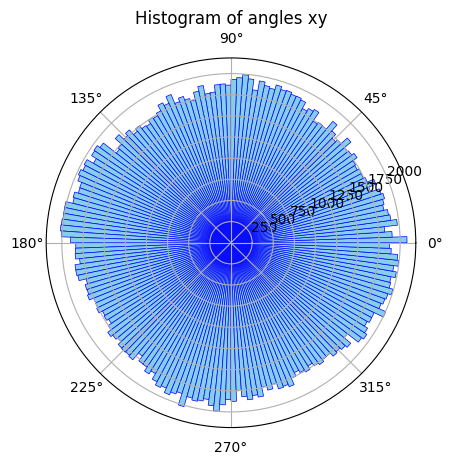

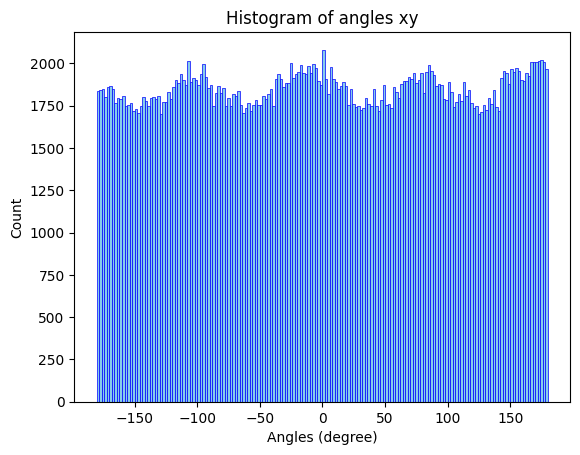

In [11]:
plot_angles_analysis(angle_xy_rad_list,angle_xy_deg_list,'Histogram of angles xy')

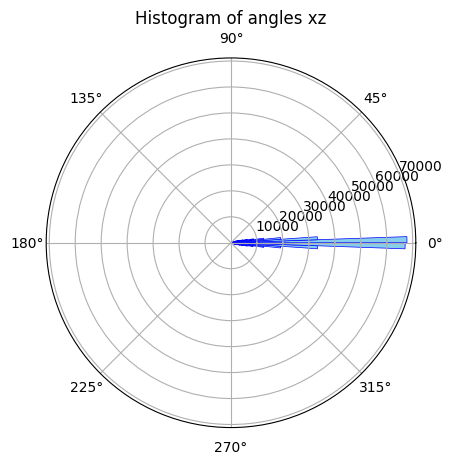

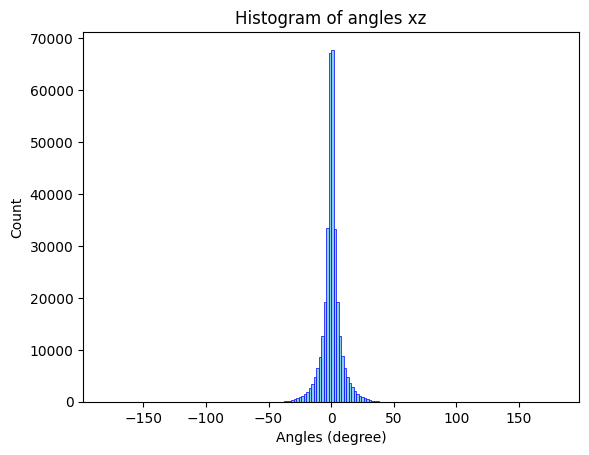

In [12]:
plot_angles_analysis(angle_xz_rad_list,angle_xz_deg_list,'Histogram of angles xz')

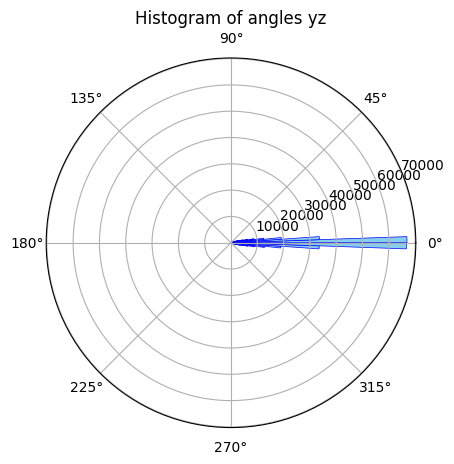

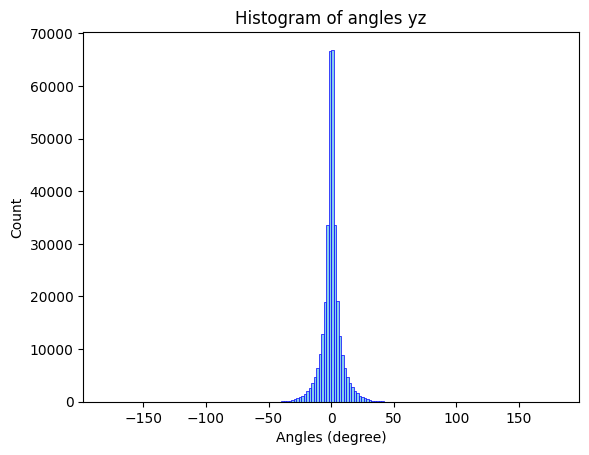

In [13]:
plot_angles_analysis(angle_yz_rad_list,angle_yz_deg_list,'Histogram of angles yz')

### Work on the pseudorapidity
1. calcul of theta (angle between z and y)
2. calcul of eta (pseudorapidity)

Pseudorapidity Min and Max values: (0.40245106402441866, 13.955272500340188)
Number of particules tracks deleted: 268 particles tracks.
Percentage of particles tracks analysed: 0.9991940479842177 %
Percentage of lost: 0.000805952015782263 %
Percentage of tracks inside 1 to 7: 0.9792467355936078 %


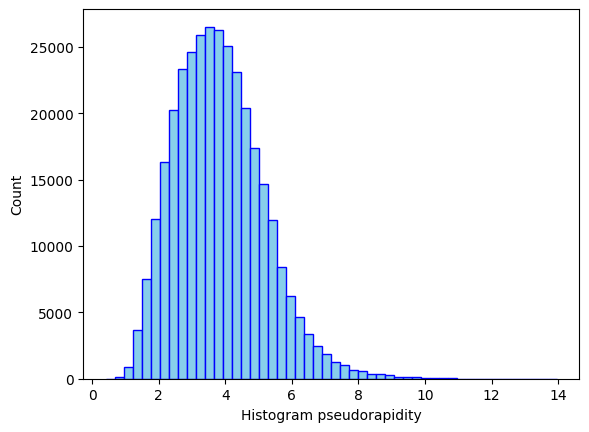

In [14]:
from math import atan2, log, tan, degrees, pi
from decimal import Decimal

pseudorapidity_eta_list = []
angle_atan2_rad_list =[]
angle_atan2_degree_list =[]

counter_0= 0


for particle in all_particles:
    hit1 = particle.track[0]    
    hit2 = particle.track[-1]

    opp = hit2.y-hit1.y
    adj = hit2.z-hit1.z

    angle_atan2_rad = atan2(opp,adj)
    angle_atan2_rad_list.append(angle_atan2_rad)

    angle_atan2_degree = degrees(angle_atan2_rad)
    angle_atan2_degree_list.append(angle_atan2_degree)

    #Pseudorapidity
    step1 = Decimal(tan(angle_atan2_rad/2))

    step2 = (abs(step1))
    if step2 == 0:
        counter_0+=1
    else:
        pseudorapidity_eta = -(log(step2))
        pseudorapidity_eta_list.append(pseudorapidity_eta)


# Analysis
maximum = heapq.nlargest(1, pseudorapidity_eta_list)[0]
minimum = heapq.nsmallest(1, pseudorapidity_eta_list)[0]
print(f'Pseudorapidity Min and Max values: {minimum,maximum}') 

percentage_of_lost = 1 -((len(all_particles)-counter_0)/len(all_particles))
print(f'Number of particules tracks deleted: {counter_0} particles tracks.')
print(f'Percentage of particles tracks analysed: {1-percentage_of_lost} %')
print(f'Percentage of lost: {percentage_of_lost} %')

lower_bound = 1
upper_bound = 7
interval_list = [x for x in pseudorapidity_eta_list if lower_bound <= x <= upper_bound]
count = sum(1 for x in interval_list)
percentage_of_tracks_inside_acceptance = count/len(all_particles)
print(f'Percentage of tracks inside 1 to 7: {percentage_of_tracks_inside_acceptance} %')

plt.hist(pseudorapidity_eta_list,color = "skyblue", edgecolor='blue',bins=50)
plt.xlabel('Histogram pseudorapidity')
plt.ylabel('Count')
plt.show()

Pseudorapidity Min and Max values: (0.40245106402441877, 13.955272500340188)
Number of particules tracks deleted: 268 particles tracks.
Percentage of particles tracks analysed: 0.9991940479842177 %
Percentage of lost: 0.000805952015782263 %
Percentage of tracks inside 1 to 7: 0.9792467355936078 %


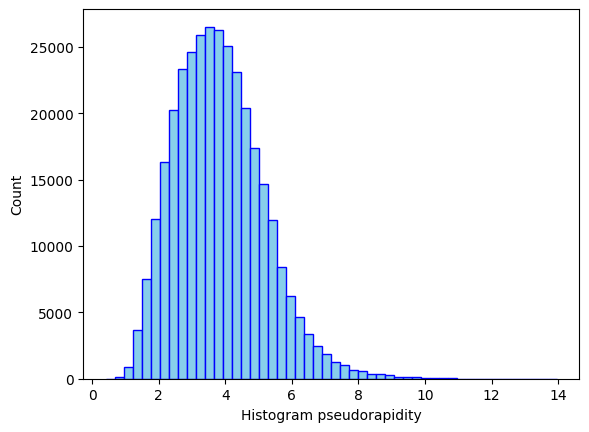

In [15]:
from math import atan2, log, tan, degrees, cos, sin
from decimal import Decimal

pseudorapidity_eta_list = []
angle_atan2_rad_list =[]
angle_atan2_degree_list =[]

counter_0= 0


for particle in all_particles:
    hit1 = particle.track[0]    
    hit2 = particle.track[-1]

    opp = hit2.y-hit1.y
    adj = hit2.z-hit1.z

    angle_atan2_rad = atan2(opp,adj)
    angle_atan2_rad_list.append(angle_atan2_rad)

    angle_atan2_degree = degrees(angle_atan2_rad)
    angle_atan2_degree_list.append(angle_atan2_degree)

    #Pseudorapidity
    # Initial formula: pseudorapidity_eta = -(log(tan(polar_angle_yz_degree/2)))
    # Seconde formula (to work on negative angles) pseudo = -0.5*(log((sin^2(angle_atan2_rad/2))/(cos^2(angle_atan2_rad/2))

    step1 = Decimal((sin(angle_atan2_rad/2) ** 2)/(cos(angle_atan2_rad/2) ** 2))
    if step1 == 0:
        counter_0+=1
    else:
        pseudorapidity_eta = -0.5*(log(step1))
        pseudorapidity_eta_list.append(pseudorapidity_eta)


# Analysis
maximum = heapq.nlargest(1, pseudorapidity_eta_list)[0]
minimum = heapq.nsmallest(1, pseudorapidity_eta_list)[0]
print(f'Pseudorapidity Min and Max values: {minimum,maximum}') 

percentage_of_lost = 1 -((len(all_particles)-counter_0)/len(all_particles))
print(f'Number of particules tracks deleted: {counter_0} particles tracks.')
print(f'Percentage of particles tracks analysed: {1-percentage_of_lost} %')
print(f'Percentage of lost: {percentage_of_lost} %')

lower_bound = 1
upper_bound = 7
interval_list = [x for x in pseudorapidity_eta_list if lower_bound <= x <= upper_bound]
count = sum(1 for x in interval_list)
percentage_of_tracks_inside_acceptance = count/len(all_particles)
print(f'Percentage of tracks inside 1 to 7: {percentage_of_tracks_inside_acceptance} %')

plt.hist(pseudorapidity_eta_list,color = "skyblue", edgecolor='blue',bins=50)
plt.xlabel('Histogram pseudorapidity')
plt.ylabel('Count')
plt.show()
